# Imports

In [16]:
import pandas as pd
from constants import LABEL_COLUMN, TEXT_COLUMN, TRAINING_DATA_PATH, EMBEDDING_SIZE, ALPHABET_COLUMN, ALPHABETS, SMALL_ALPHABETS, TINY_ALPHABETS
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score

# Data

In [3]:
df = pd.read_csv("data/train_data_with_embedding_per_column.csv")

# Replace label NaN with the string "nan" (the string "nan" is interpreted as a NaN value by pandas)
df["Label"].replace(to_replace=np.nan, value="nan", inplace=True)

# Remove label with only 1 occurence
df = df.groupby("Label").filter(lambda x: len(x) > 1)

C:\Users\camil\AppData\Local\Temp\ipykernel_6272\1044635865.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Label"].replace(to_replace=np.nan, value="nan", inplace=True)


In [4]:
print(df[["ID", "Label", "Text"]].info())

<class 'pandas.core.frame.DataFrame'>
Index: 38850 entries, 0 to 38853
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      38850 non-null  int64 
 1   Label   38850 non-null  object
 2   Text    38850 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None


In [5]:
def detect_alphabet(text):
    detected = ""
    
    for char in text:
        char_code = ord(char)
        
        for alphabet, (start, end) in ALPHABETS.items():
            if start <= char_code <= end:
                detected = alphabet
    
    return detected if detected else "Inconnu"

df[ALPHABET_COLUMN] = df[TEXT_COLUMN].apply(detect_alphabet)

In [6]:
df[ALPHABET_COLUMN].value_counts()

Alphabet
Latin         28848
Cyrillic       3259
Arabic         2413
Devanagari     1577
Inconnu        1247
Chinese         523
Hebrew          228
Georgian        204
Greek           200
Gujarati        100
Korean           96
Thai             90
Hiragana         50
Katakana         15
Name: count, dtype: int64

In [7]:
df[df[ALPHABET_COLUMN].isin(TINY_ALPHABETS)]["Text"].count()

np.int64(351)

In [8]:
df[df[ALPHABET_COLUMN].isin(SMALL_ALPHABETS)]["Text"].count()

np.int64(632)

In [9]:
df[~df[ALPHABET_COLUMN].isin(SMALL_ALPHABETS + TINY_ALPHABETS)]["Text"].count()

np.int64(37867)

In [10]:
# Separating the data into training and testing data
from train_roberta import load_data

# Load data
filepath = "data/train_submission.csv"
texts, labels, label_to_id = load_data(filepath)

# Split data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Train data
X_train = pd.merge(pd.DataFrame(train_texts, columns=["Text"]), df, on=["Text"], how="inner")
X_train["Label"].replace(to_replace=np.nan, value="nan", inplace=True)

# Roberta predictions
predictions_roberta = pd.read_csv("data/train_predictions.csv")

# Test predictions
X_test = pd.merge(pd.DataFrame(test_texts, columns=["Text"]), predictions_roberta, on=["Text"], how="inner")
X_test = pd.merge(X_test, df, on=['Text', 'ID', 'Usage', 'Label'], how="inner")
X_test["Label"].replace(to_replace=np.nan, value="nan", inplace=True)
X_test["Prediction"].replace(to_replace=np.nan, value="nan", inplace=True)

# Accuracy with Roberta only
print("Accuracy with Roberta only:", (X_test["Label"] == X_test["Prediction"]).mean())

c:\Users\camil\OneDrive\Documents\CentraleSupelec\Cours\3A\AdvancedNLP\kaggle_anlp\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\camil\AppData\Local\Temp\ipykernel_6272\2373155748.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train["Label"].replace(to_replace=np.nan, value="nan", inplace=True)


Accuracy with Roberta only: 0.8366662366146304


C:\Users\camil\AppData\Local\Temp\ipykernel_6272\2373155748.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test["Label"].replace(to_replace=np.nan, value="nan", inplace=True)
C:\Users\camil\AppData\Local\Temp\ipykernel_6272\2373155748.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

# Training for alphabet with up to 5 different languages

In [11]:
small_classifiers = {}

for small_alphabet in SMALL_ALPHABETS:

    X_train_small = X_train[X_train[ALPHABET_COLUMN] == small_alphabet]
    X_test_small = X_test[X_test[ALPHABET_COLUMN] == small_alphabet]

    classifier = RandomForestClassifier()
    classifier.fit(X_train_small[[f"embedding_{i}" for i in range(EMBEDDING_SIZE)]], X_train_small[LABEL_COLUMN])
    
    small_classifiers[small_alphabet] = classifier


# Test

C:\Users\camil\AppData\Local\Temp\ipykernel_6272\1631705242.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds_tiny_alphabet["Prediction"] = tiny_alphabet_matching[tiny_alphabet]
C:\Users\camil\AppData\Local\Temp\ipykernel_6272\1631705242.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds_small_alphabet["Prediction"] = classifier.predict(preds_small_alphabet[[f"embedding_{i}" for i in range(EMBEDDING_SIZE)]])
C:\Users\camil\AppData\Local\Temp\ipykernel_6272\1631705242.py:22: SettingWithCopyWa

Accuracy Tiny: 0.9864864864864865
Accuracy Small: 0.9243697478991597
Accuracy Large Alphabets: 0.8317183021700559
Total accuracy: 0.8347074468085106
f1-score: 0.8342368052921412


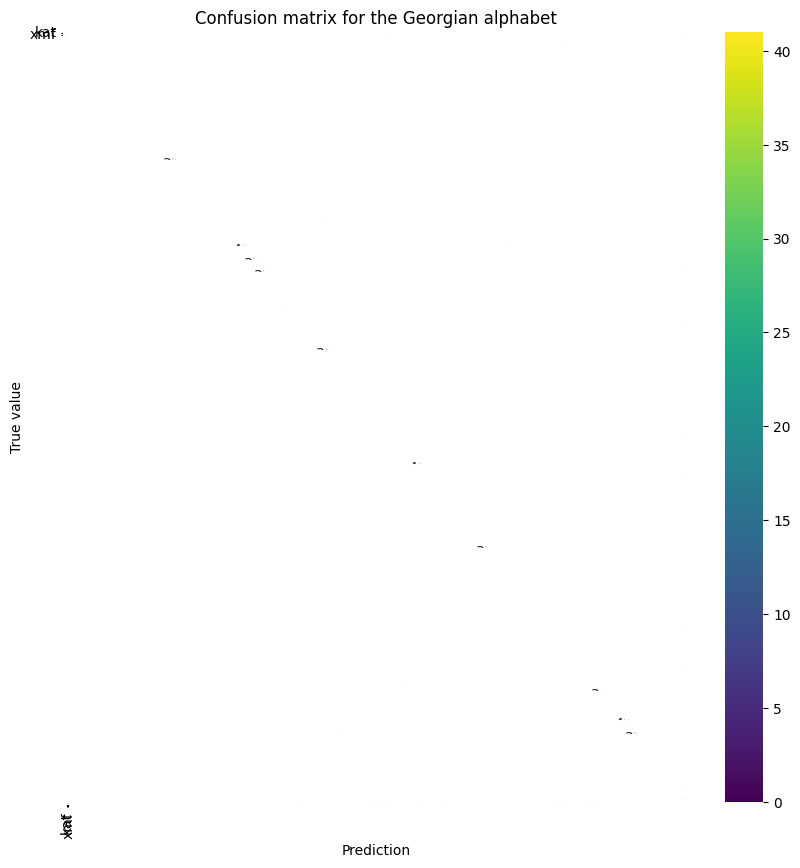

In [ ]:
# Alphabet with only one language
preds_tiny_alphabets = {}
weights_tiny_alphabets = {}
tiny_alphabet_matching = { "Thai":"tha", "Hiragana": "jpn", "Gujarati":"guj", "Korean": "kor","Katakana": "jpn" }
for tiny_alphabet in TINY_ALPHABETS:
    preds_tiny_alphabet = X_test[X_test[ALPHABET_COLUMN] == tiny_alphabet]
    preds_tiny_alphabet["Prediction"] = tiny_alphabet_matching[tiny_alphabet]
    preds_tiny_alphabets[tiny_alphabet] = preds_tiny_alphabet
    weights_tiny_alphabets[tiny_alphabet] = len(preds_tiny_alphabet)
 
accuracy_tiny = 0
for key in preds_tiny_alphabets:
    accuracy_tiny += (preds_tiny_alphabets[key]["Label"] == preds_tiny_alphabets[key]["Prediction"]).sum()
print("Accuracy Tiny:", accuracy_tiny / sum(weights_tiny_alphabets.values()))
    
# Alphabet with up to 5 different languages
preds_small_alphabets = {}
weights_small_alphabets = {}
for small_alphabet in SMALL_ALPHABETS:
    classifier = small_classifiers[small_alphabet]
    preds_small_alphabet = X_test[X_test[ALPHABET_COLUMN] == small_alphabet]
    preds_small_alphabet["Prediction"] = classifier.predict(preds_small_alphabet[[f"embedding_{i}" for i in range(EMBEDDING_SIZE)]])
    preds_small_alphabets[small_alphabet] = preds_small_alphabet
    weights_small_alphabets[small_alphabet] = len(preds_small_alphabet)

accuracy_small = 0
for key in preds_small_alphabets:
    accuracy_small += (preds_small_alphabets[key]["Label"] == preds_small_alphabets[key]["Prediction"]).sum()
    
print("Accuracy Small:", accuracy_small / sum(weights_small_alphabets.values()))

# Alphabet with more than 5 different languages
large_alphabets = ALPHABETS.keys() - set(SMALL_ALPHABETS + TINY_ALPHABETS)
preds_large_alphabets = {}
weights_large_alphabets = {}
for alphabet in large_alphabets:
    preds_large_alphabet = X_test[X_test[ALPHABET_COLUMN] == alphabet]
    preds_large_alphabets[alphabet] = preds_large_alphabet
    weights_large_alphabets[alphabet] = len(preds_large_alphabet)

accuracy_large = 0
for key in preds_large_alphabets:
    accuracy_large += (preds_large_alphabets[key]["Label"] == preds_large_alphabets[key]["Prediction"]).sum()
print("Accuracy Large Alphabets:", accuracy_large / sum(weights_large_alphabets.values()))


# Accuracy and f1-score
from sklearn.metrics import f1_score

preds = pd.concat([preds_tiny_alphabets[key] for key in preds_tiny_alphabets] + [preds_small_alphabets[key] for key in preds_small_alphabets] + [preds_large_alphabets[key] for key in preds_large_alphabets])
print("Total accuracy:", (preds["Label"] == preds["Prediction"]).mean())
print("f1-score:", f1_score(preds["Label"], preds["Prediction"], average="weighted"))